In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense , Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping , LearningRateScheduler
import keras.backend as K
from keras.initializers import lecun_uniform
from keras import metrics , regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


Using TensorFlow backend.


In [2]:
def splitData(X,Y,rate):
    X_train = X[:int(X.shape[0]*rate)]
    Y_train = Y[:int(Y.shape[0]*rate)]
    X_val = X[int(X.shape[0]*rate):]
    Y_val = Y[int(Y.shape[0]*rate)-1:]
    return X_train, Y_train, X_val, Y_val

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def metric_R2(y_true,y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 20.0
    lrate = initial_lrate * np.power(drop,np.floor((1+epoch)/epochs_drop))
    return lrate    

df = pd.read_csv("data/2330_indicators.csv")
X_train = df[:-1].values

y_train = df.loc[1:,['closed']].values
X_train , Y_train , X_val , Y_val = splitData(X_train,y_train,0.8)
print(X_val.shape,Y_val.shape)

(1258, 10) (1259, 1)


In [3]:
sc_X = MinMaxScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.transform(X_val)
sc_Y = MinMaxScaler()
Y_train_sc = sc_Y.fit_transform(Y_train)
Y_val_sc = sc_Y.transform(Y_val)

In [4]:
X_train_steps = []
Y_train_steps = []
for i in range(20, len(X_train_sc)):  # 1258 是訓練集總數
    X_train_steps.append(X_train_sc[i-20:i])
    Y_train_steps.append(Y_train_sc[i])
X_train, Y_train = np.array(X_train_steps), np.array(Y_train_steps)

X_val_steps = []
Y_val_steps = []
for i in range(20,len(X_val_sc)):
    X_val_steps.append(X_val_sc[i-20:i])
    Y_val_steps.append(Y_val_sc[i])
X_val , Y_val = np.array(X_val_steps) , np.array(Y_val_steps)


In [5]:
epochs = 380
batch_size = 32
LSTM_num = 3
units = 16

model_lstm = Sequential()
#use L2 to improve overfit
model_lstm.add(LSTM(units,input_shape=X_train.shape[1:],activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.0009),return_sequences=True)) 
#model_lstm.add(Dropout(0.001))

model_lstm.add(LSTM(units,kernel_regularizer=regularizers.l2(0.0009),return_sequences=True))
#model_lstm.add(Dropout(0.001))

model_lstm.add(LSTM(units,kernel_regularizer=regularizers.l2(0.0009),return_sequences=False))
#model_lstm.add(Dropout(0.001))

model_lstm.add(Dense(1))
model_lstm.summary()
model_lstm.compile(loss='mean_squared_error',optimizer="Adam",metrics=[rmse])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 16)            1728      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 5,969
Trainable params: 5,969
Non-trainable params: 0
_________________________________________________________________


In [6]:
#decay lr by half every 10 epoch
lrate = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=1)
history = model_lstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, shuffle=False,validation_data=(X_val,Y_val),callbacks=[early_stop])
y_pred_test_lstm = model_lstm.predict(X_val)
y_train_pred_lstm = model_lstm.predict(X_train)
r2score = r2_score(Y_val, y_pred_test_lstm)
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))

Train on 5008 samples, validate on 1238 samples
Epoch 1/380
5008/5008 [==============================] - 5s 1ms/step - loss: 0.1046 - rmse: 0.1075 - val_loss: 0.1475 - val_rmse: 0.2526
Epoch 2/380
5008/5008 [==============================] - 3s 689us/step - loss: 0.0575 - rmse: 0.0616 - val_loss: 0.0430 - val_rmse: 0.0426
Epoch 3/380
5008/5008 [==============================] - 3s 694us/step - loss: 0.0392 - rmse: 0.0409 - val_loss: 0.0334 - val_rmse: 0.0432
Epoch 4/380
5008/5008 [==============================] - 3s 689us/step - loss: 0.0307 - rmse: 0.0366 - val_loss: 0.0268 - val_rmse: 0.0344
Epoch 5/380
5008/5008 [==============================] - 3s 695us/step - loss: 0.0263 - rmse: 0.0380 - val_loss: 0.0232 - val_rmse: 0.0371
Epoch 6/380
5008/5008 [==============================] - 4s 709us/step - loss: 0.0229 - rmse: 0.0382 - val_loss: 0.0214 - val_rmse: 0.0440
Epoch 7/380
5008/5008 [==============================] - 3s 683us/step - loss: 0.0203 - rmse: 0.0382 - val_loss: 0.0197 

5008/5008 [==============================] - 4s 717us/step - loss: 0.0029 - rmse: 0.0258 - val_loss: 0.0056 - val_rmse: 0.0462
Epoch 60/380
5008/5008 [==============================] - 4s 794us/step - loss: 0.0029 - rmse: 0.0258 - val_loss: 0.0054 - val_rmse: 0.0453
Epoch 61/380
5008/5008 [==============================] - 4s 749us/step - loss: 0.0028 - rmse: 0.0257 - val_loss: 0.0052 - val_rmse: 0.0444
Epoch 62/380
5008/5008 [==============================] - 4s 724us/step - loss: 0.0028 - rmse: 0.0256 - val_loss: 0.0050 - val_rmse: 0.0435
Epoch 63/380
5008/5008 [==============================] - 3s 671us/step - loss: 0.0028 - rmse: 0.0256 - val_loss: 0.0048 - val_rmse: 0.0430
Epoch 64/380
5008/5008 [==============================] - 4s 773us/step - loss: 0.0028 - rmse: 0.0255 - val_loss: 0.0047 - val_rmse: 0.0423
Epoch 65/380
5008/5008 [==============================] - 4s 742us/step - loss: 0.0027 - rmse: 0.0254 - val_loss: 0.0046 - val_rmse: 0.0420
Epoch 66/380
5008/5008 [=========

5008/5008 [==============================] - 4s 753us/step - loss: 0.0022 - rmse: 0.0229 - val_loss: 0.0019 - val_rmse: 0.0258
Epoch 118/380
5008/5008 [==============================] - 4s 705us/step - loss: 0.0022 - rmse: 0.0229 - val_loss: 0.0020 - val_rmse: 0.0268
Epoch 119/380
5008/5008 [==============================] - 3s 690us/step - loss: 0.0021 - rmse: 0.0228 - val_loss: 0.0019 - val_rmse: 0.0256
Epoch 120/380
5008/5008 [==============================] - 4s 714us/step - loss: 0.0021 - rmse: 0.0228 - val_loss: 0.0020 - val_rmse: 0.0264
Epoch 121/380
5008/5008 [==============================] - 3s 696us/step - loss: 0.0021 - rmse: 0.0228 - val_loss: 0.0019 - val_rmse: 0.0253
Epoch 122/380
5008/5008 [==============================] - 4s 720us/step - loss: 0.0021 - rmse: 0.0228 - val_loss: 0.0020 - val_rmse: 0.0261
Epoch 123/380
5008/5008 [==============================] - 4s 703us/step - loss: 0.0021 - rmse: 0.0227 - val_loss: 0.0019 - val_rmse: 0.0251
Epoch 124/380
5008/5008 [==

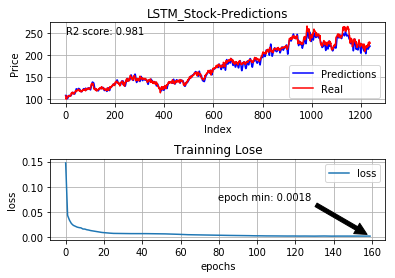

In [7]:
val_loss = history.history['val_loss']

plt.figure(1)
plt.subplot(211)
plt.plot(sc_Y.inverse_transform(y_pred_test_lstm),'b',label='Predictions')
plt.plot(sc_Y.inverse_transform(Y_val),'r',label='Real')
plt.title('LSTM_Stock-Predictions',)
plt.xlabel('Index')
plt.ylabel('Price')
score = "{:0.3f}".format(r2score)
plt.text(0,plt.ylim()[1]*0.9,'R2 score: '+ score)
plt.legend(loc='lower right')


plt.grid(True)


plt.subplot(212)
plt.title("Trainning Lose")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(val_loss,label='loss')
plt.legend(loc='upper right')
notate_xy = [np.argmin(val_loss),np.min(val_loss)]
plt.annotate('epoch min: {:0.4f}'.format(notate_xy[1]), xy=notate_xy, xytext=(np.argmin(val_loss)*0.5, np.max(val_loss)*0.5),arrowprops=dict(facecolor='black', shrink=0.05),)
plt.grid(True)
plt.subplots_adjust(hspace=0.7)
saveName = 'LSTM_layers'+str(LSTM_num)+'_units'+str(units)+'_epochs'+str(epochs)+'_batch_size'+str(batch_size)+'_r2score~'+str(score)
plt.savefig('pltfigs/'+saveName+'.png',dpi=200)
plt.show()

In [8]:
model_lstm.save(saveName+'.h5')

In [9]:
def rmse(val , pred):
    return np.mean(np.divide(pred,val))
print(str(rmse(Y_val,y_pred_test_lstm)))

0.9865274374280615
